# Chapter 02 - Data and Sampling Distributions

## Random Sampling and Sample Bias

*Random sampling* is the process of drawing a set of elements (or individuals) from a larger set (called population) in a random way. Random sampling can be done *with replacement*, where each sampled element returns to the population after being sampled for possible future selection. Or else, it can be done *without replacement*, which implies that the sampled element does not return to the population once selected.

In stratified sampling, the population is divided into groups (strata), and random samples are taken from each group (stratum).

**Size vs Quality: When does size matter?**

In most scenarios, data quality is more important than data quantity, and random sampling can help reducing bias and facilitate quality improvement. However, **when data is very sparse**, sampling won't help as much. In those cases, having a large amount of data may be even more important.  

## Selection Bias

*Selection bias* refers to the practice of selectively choosing data - consciously or unconsciouly - in a way that leads to a conclusion that is misleading of ephemeral.

Keep in mind the following paragraph copied directly from the book:

"If you specify a hypothesis and conduct a well-designed experiment to test it, you can have high confidence in the conclusion. This is frequently not what occurs, however. Often, one looks at available data and tries to discern patterns. But are the patterns real? Or are they just the product of data snooping—that is, extensive hunting through the data until something interesting emerges? There is a saying among statisticians: 'If you torture the data long enough, sooner or later it will confess.'"

**The correct procedure to avoid selection bias is to specify a hypothesis and then collecting data following randomization and random sampling principles ensures against bias.**

All other forms of data analysis run the risk of selection bias (through repeated running models until you find something "interesting", data snooping in research, and after-the-fact selection of interesting events - which happens when you first run a research on the dataset before specifying a hypothesis.)

## Sampling Distribution of a Statistic

The term _sampling distribution_ of a statistic refers to the distribution of some sample statistic (mean, median, and so on) over many samples drawn from the sample population.

As a consequence of the central limit theorem, the distribution of a sample statistic is likely to have a bell-shaped distribution even if the data distribution is not normal distributed.

For illustration, consider the following example:

### Central Limit Theorem

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
loans_income = pd.read_csv("../data/loans_income.csv").squeeze('columns')
loans_income.head()

0     67000
1     52000
2    100000
3     78762
4     37041
Name: x, dtype: int64

In [12]:
sample_data = pd.DataFrame({
    "income": loans_income.sample(1000),
    "type": "Data"
})

sample_mean_05 = pd.DataFrame({
    "income": [loans_income.sample(5).mean() for _ in range(1000)],
    "type": "Mean of 5"
})

sample_mean_20 = pd.DataFrame({
    "income": [loans_income.sample(20).mean() for _ in range(1000)],
    "type": "Mean of 20"
})

results = pd.concat([sample_data, sample_mean_05, sample_mean_20])

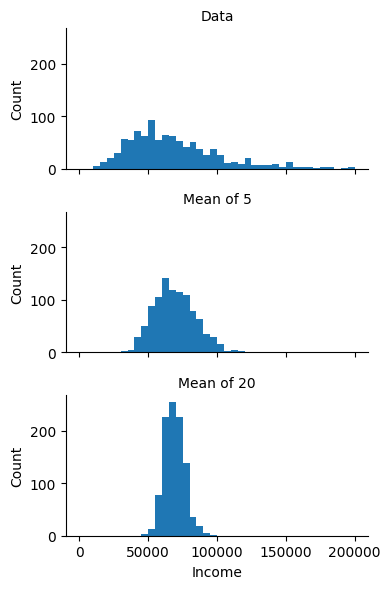

In [13]:
g = sns.FacetGrid(results, col='type', col_wrap=1, 
                  height=2, aspect=2)
g.map(plt.hist, 'income', range=[0, 200000], bins=40)
g.set_axis_labels('Income', 'Count')
g.set_titles('{col_name}')

plt.tight_layout()
plt.show()

The central limit theorem allows normal-approximation formulas like the t-distribution to be used in calculating sampling distributions for inference—that is, confidence intervals and hypothesis tests

### Standard Error

The metric used to measure the variability of a sampling distribution for a statistic is called *standard error*. and is it given by:

$$
SE = \frac{s}{\sqrt{n}} \text{, where $s$ is the standard deviation of the data distribution and $n$ is the sample size.}
$$

In practice, this approach of collecting new samples to estimate the standard error is typically not feasible (and statistically very wasteful). Fortunately, it turns out that it is not necessary to draw brand new samples; instead, you can use bootstrap resamples.

## The Bootstrap

The boostrap is a procedure to estimate sampling distribution of a statistic, or of model parameters. The idea is as follows:

1. **Draw additional samples** from the sampling distribution, **with replacement**.
2. **Recalculate** the statistic or model for **each resample**.

Bootstrapping does not involve any assumption about the data or the sample statistic being normally distributed.

To be more specific, take the mean, and consider the bootstrap resampling of the mean:

1. Draw a sample value, record it, and then replace it.
2. Repeat $n$ times.
3. Record the mean of the $n$ resampled values.
4. Repeat steps 1-3 $R$ times.
5. Use the $R$ results to: \
    a) calculate their standard deviation (this estimates the sample mean standard error). \
    b) produce histogram of boxplot. \
    c) Find a confidence interval.
    
    

In [21]:
# bootstrap
from sklearn.utils import resample

results = []
for nrepeat in range(1000):
    sample = resample(loans_income)
    results.append(sample.median())

results = pd.Series(results)

print('Bootstrap Statistics:')
print(f'original: {loans_income.median()}')
print(f'bias: {results.mean() - loans_income.median()}')
print(f'std. error: {results.std()}')

Bootstrap Statistics:
original: 62000.0
bias: -63.41449999999895
std. error: 195.4980496761468


## (Bootstrap) Confidence Intervals

We have introduced so far the concepts of frequency tables, histograms, boxplots, and standard errors. Confidence intervals are just another way of assessing the potential error in a sample estimate.

Since this subject is very important, keep in mind the key terms:

**Confidence level** \
    the percentage of confidence intervals, constructed in the same way from the same population, that are expected to contain the statistic of interest.

Regarding building confidence intervals using the bootstrap strategy, we can think of a 90% CI as follows:\
    It is the interval that encloses the central 90% of the bootstrap sampling distribution of a statistic.
    
The algorithm for a **bootstrap confidence interval** is as follows:

1. Draw a random sample of size $n$ with replacement from the data (a resample).
2. Record the statistic of interest for the resample.
3. Repeat steps 1-2 many ($R$) times.
4. For an $x$% confidence interval, trim $[(100-x)/2]$% of the R resample result from either end of the distribution.
5. The trim points are the endpoints of an $x$% bootstrap confidence interval.

In [102]:
# bootstrap confidence interval
np.random.seed(seed=3)  

# create a sample of 20 loan income
loans_income20 = resample(loans_income, n_samples=20, replace=False)
results = []
for nrepeat in range(500):
    sample = resample(loans_income20)  # sample with replacement
    results.append(sample.mean())
    
results = pd.Series(results)
sorted_results = results.sort_values(ignore_index=True)

lower_endpoint, upper_endpoint = results.quantile([0.05, 0.95])
mean = results.mean()

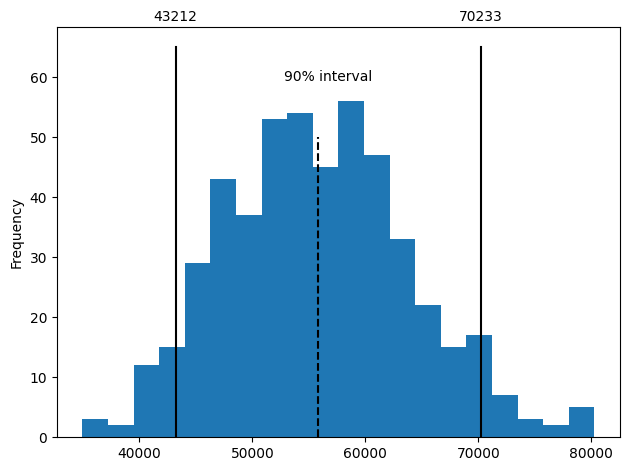

In [103]:
fig, ax = plt.subplots(1, 1)

results.plot.hist(ax=ax, bins=20)

for x in [lower_endpoint, upper_endpoint]:
    ax.plot([x, x], [0, 65], color='black')
    ax.text(x, 70, f'{x:.0f}', 
            horizontalalignment='center', verticalalignment='center')
ax.text((lower_endpoint + upper_endpoint) / 2, 60, '90% interval',
        horizontalalignment='center', verticalalignment='center')
# mean
ax.plot([mean, mean], [0, 50], color='black', linestyle='--')

plt.tight_layout()
plt.show()

## Normal Distribution

The normal distribution plays a central role in classical statistics. Given that a random variable $X$ follows a normal distribution with mean $\mu$ and variance $\sigma^2$, we write that:

$$
f_X(x) \sim \frac{1}{\sqrt{2\pi\sigma^2}}e^{\frac{(x-\mu)}{2\sigma^2}}
$$

To compare any distribution to a normal distribution, we must compute the z-distribution of the distribution we want to compare with. The z-score can be computed by subtracting the mean from the values of the distribution and dividing by the standard deviation:

$$
z = \frac{x - \mu}{\sigma}
$$

A visual tool to compare the distribution with a normal one is the QQ-Plot. A QQ-Plot is used to visually determine how close a sample is to a specified distribution—in this case, the normal distribution. The QQ-Plot orders the z-scores from low to high and plots each value’s z-score on the y-axis; the x-axis is the corresponding quantile of a normal distribution for that value’s rank. Since the data is normalized, the units correspond to the number of standard deviations away from the mean. **If the points roughly fall on the diagonal line, then the sample distribution can be considered close to normal**.

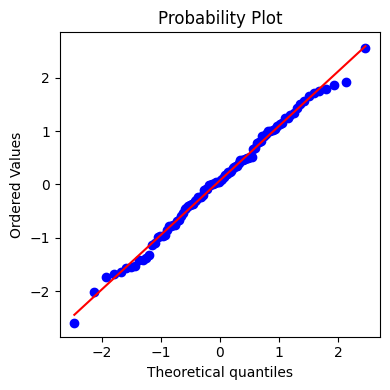

In [108]:
fig, ax = plt.subplots(figsize=(4, 4))
norm_sample = stats.norm.rvs(size=100)
stats.probplot(norm_sample, plot=ax)

plt.tight_layout()
plt.show()

## Long-Tailed Distributions

While the normal distribution is often appropriate and useful with respect to the distribution of errors and sample statistics, it typically does not characterize the distribution of raw data. Look for example at the QQ-Plot for the daily stock returns for Netflix (NFLX):

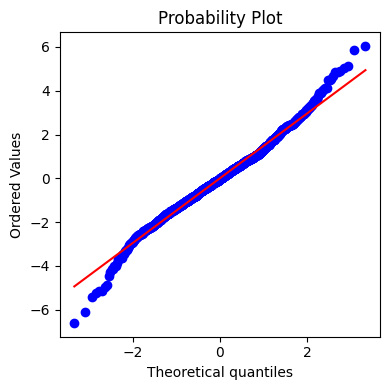

In [109]:
sp500_px = pd.read_csv("../data/sp500_data.csv.gz", index_col=0)

nflx = sp500_px.NFLX
nflx = np.diff(np.log(nflx[nflx>0]))

fig, ax = plt.subplots(figsize=(4, 4))

from scipy import stats
stats.probplot(nflx, plot=ax)

plt.tight_layout()
plt.show()

We can see that the points are far below the line for low values and far above the line for high values, indicating the data are not normally distributed. This means that we are much more likely to observe extreme values than would be expected if the data had a normal distribution.

## Student's t-distribution

The t-distribution arose from the question: "What is the sampling distribution of the mean
of a sample, drawn from a larger population?" and it was answered by W. S. Gosset in 1908.

If you want to construct a confidence interval using the t-distribution then let $n$ be the sample of size for which the sample mean $\bar{x}$ has been calculated. If $s$ is the sample standard deviation, a 90% confidence interval around the sample mean is given by:

$$
\bar{x} \pm t_{n-1}(0.05) \frac{s}{\sqrt{n}}
$$

where $t_{n-1}(.05)$ is the value of the t-statistic, with $(n-1)$ degrees of freedom, that chops off 5% of the t-distribution at either end.

The t-distribution is widely used as a reference basis for the distribution of sample means, differences between two sample means, regression parameters, and more.

In [122]:
# 90% confidence interval with t-distribution
np.random.seed(3)

# create a sample of 20 loan income
sample = resample(loans_income, n_samples=1000, replace=False)
xbar = sample.mean()
t_statistic = 1.645
s = results.std()
n = 1000

test_range = t_statistic*s/np.sqrt(n)

CI = [xbar - test_range, xbar + test_range]
print(f'Mean is {xbar}')
print(f'90% CI is {CI}')

Mean is 67275.158
90% CI is [66849.50635474508, 67700.8096452549]


## Binomial Distribution

A binomial random variable models the number of success in $n$ trials (or repetitions) of the same experiment. If a random variable $X$ follows a binomial distribution, then, the probability of $k$ successes among $n$ trials ($k < n$) is given by:

$$
p^k(1 - p)^{n-k}
$$

where $p$ is the probability of success. With this distribution, we can answer questions like:

_If the probability of a click converting to a sale is 0.02, what is the probability of observing 0 sales in 200 clicks?_

To answer this question, let's collect some facts:

- The probability of success (a click converts to a sale) is 0.02
- The number of trials is $n = 200$
- we are interest in know the situation where no sale is observed. Hence, $k = 0$.

Thus, the answer is given by $(0.02)^0 (1 - 0.02)^{200 - 0}$, which we can evaluate using python:

In [123]:
from scipy import stats
stats.binom.pmf(0, n=200, p=0.02)

0.0175879466057215

## Chi-Square Distribution

An important idea in statistics is departure from expectation, especially with respect to category counts. By expectation, we mean the null model or the "null hypothesis", or the assumed status quo.

When you have a situation with categories and you want to test whether the values for one category are independent of another, and you have the **counts** of the number in each of the cells of the data table, then you can use the chi-square test statistic. This statistic measures the extent to which results depart from the null expectation.

The chi-square distribution is used to perform goodness-of-fit tests in order to compare distributions. It is also useful for determining whether multiple treatments (an A/B/C test) differ from one another in their effects.

## F-Distribution

As a counterpart of the chi-square distribution which deals with counts of data, the F-distribution deals with measured continuous values. It is use can be similar to the Chi-Square distribution: A common procedure in scientific experimentation is to test multiple treatments across groups—say, different fertilizers on different blocks of a field. This is similar to the A/B/C test referred to in the chi-square distribution.

However, in this case we are interested in the extent to which differences among group means are greater than we might expect under normal random variation. The F-statistic measures this and is the ratio of the variability among the group means to the variability within each group (also called residual variability). This comparison is termed an analysis of variance.

The distribution of the F-statistic is the frequency distribution of all the values that would be produced by randomly permuting data in which all the group means are equal (i.e., a null model).

## Poisson and Related Distributions

Processes that produce events randomly at a given overall rate spread over time or space can be modeled by som distributions such as:

**The Poisson Distribution**

Models the frequency distribution of the **number of events** in sampled units of time or space. Using this distribution to model data, we can answer queuing questions like: 

_"How much capacity do we need to be 95% sure of fully processing the internet traffic that arrives on a server in any five second period?"_

it is described by the rate parameter $\lambda$, which is the mean number of events that occurs in a specified interval of time or space. The variance of a Poisson distribution is also $\lambda$.

The PMF of a Poisson R.V. X is given by $f_X(k) \sim \frac{\lambda^k e^{-\lambda}}{k!}$, for $k = 0, 1, ...$. The `scipy` function to sample from a Poisson distribution is given by:

```python
stats.poisson.rvs(mu=2, size=100)  # use mu instead of lambda
``` 

**The exponential Distribution**

The exponential distribution models the time of distance from one event to the next event. It is also used in engineering to model time to failure, and in process management to model, for example, the time required per service call.

It is also described by the rate parameter $\lambda$.

The PDF of a exponential R.V. is give by $f_X(x) \sim \lambda e^{-\lambda x}$, for $x > 0$.

```python
stats.expon.rvs(scale=1/0.2, size=100)  # pass lambda=0.2 via the scale parameter which is 1/lambda  
```

**The Weibull Distribution**

In many cases, the event rate does not remain constant over time. If the period over which it changes is much longer than the typical interval between events, there is no problem; you just subdivide the analysis into the segments where rates are relatively constant. If, however, the event rate changes over the time of the interval, the exponential (or Poisson) distributions are no longer useful. In such cases, we use the Weibull Distribution.

The Weibull distribution is similar to the exponential distribution, with the addition of two other parameters:

- $\beta$: shape parameter. If $\beta > 1$, the probability of an event increases over time; if $\beta < 1$, the probability decreases.
- $\eta$: scale parameter. Because the Weibull distribution is used with time-to-failure analysis instead of event rate, the second parameter is expressed in terms of characteristic life, rather than in terms of the rate of events per interval.

Estimation using the Weibull Distribution includes also estimates $\beta$ and $\eta$. The following code would generate 100 random numbers (lifetimes) from a Weibull distribution with shape of 1.5 and characteristic life of 5,000:

```python
stats.weibull_min.rvs(1.5, scale=5000, size=100)
```